Когда нажимается кнопка анализа, запускается этот код, который показывает разные графики с подписями и таблицу по предсказанию с датами 

In [1]:
from sklearn import tree
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

from IPython.display import SVG 
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
import math as m
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import glob,os

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


/opt/homebrew/Caskroom/miniconda/base/envs/gisflakes/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#cd archive/

/Users/maria/Desktop/Курсы/Хакатон_Честный_знак/archive


In [5]:
#вместо конкретно этого файла должен быть загруженный пользователем файл 
out = pd.read_csv("Данные о выводе товаров из оборота с 2021-11-22 по 2022-11-21.csv")

In [305]:
out.head()

,dt,gtin,prid,inn,id_sp_,type_operation,price,cnt
0,2021-11-22,5A3E5F7B2D093D1D6CB3CF93BA9AC8A6,DC7432556B58D454B4E37F0F0D1E663D,B035ED5D308BC70E5EA9342B6DBF5810,19485F700068E6A9A8593AFDE9803638,Продажа конечному потребителю в точке продаж,3500,1
1,2021-11-22,9A2202A48FC5E462C44B78B0C79E1DBD,D18B1B470E57871FAB5B4E949E256BB4,DD486FED86564603D2CD7CF9EED2C458,C2969A4C8A40C12902EAD4936E303045,Продажа конечному потребителю в точке продаж,56714,1
2,2021-11-22,877ABE9DE14E0B510DFC8DE63EEFA817,62B5EAEF59E6693F44B1074C1140BF45,62B5EAEF59E6693F44B1074C1140BF45,5637334F301773E28AE8730713E6D5F7,Продажа конечному потребителю в точке продаж,74314,1
3,2021-11-22,B004F889F17F8AB365C494B3D0D06E1A,D7326D87A37D73AF19AF53668A7116D6,D7326D87A37D73AF19AF53668A7116D6,0FF56DEC16050D3B6372F2CB1BD6DFCB,Продажа конечному потребителю в точке продаж,4999,1
4,2021-11-22,E1C0503EA9201D56D7173CB4CA4A6AFA,50955BB0B97298EEAEB1F6CF9712F37A,39FFA592BE77CA7DE37C65C1B8423E8C,9E660AA1DE428BA88D1942DB2824BDAB,Продажа конечному потребителю в точке продаж,29857,1


# аналитика продаж 

In [4]:
#По кнопке Выдерите ИНН в окне выбора вылезает только один сейчас - 89F1BFD156A04E3D9B28C7FD6BED4F2F'
#По кнопке Выберите gtin - тоже только один 1248F88441BCFC563FB99D77DB0BB80D

In [15]:
gtin1 = out.loc[out['inn'] == '89F1BFD156A04E3D9B28C7FD6BED4F2F']
gtin1 = gtin1.loc[gtin1['gtin'] == '1248F88441BCFC563FB99D77DB0BB80D']

In [ ]:
gtin1 = gtin1.set_index('dt')

In [ ]:
#Визуализация изменения реализации товара во времени (среднее по неделям)

<AxesSubplot:xlabel='dt'>

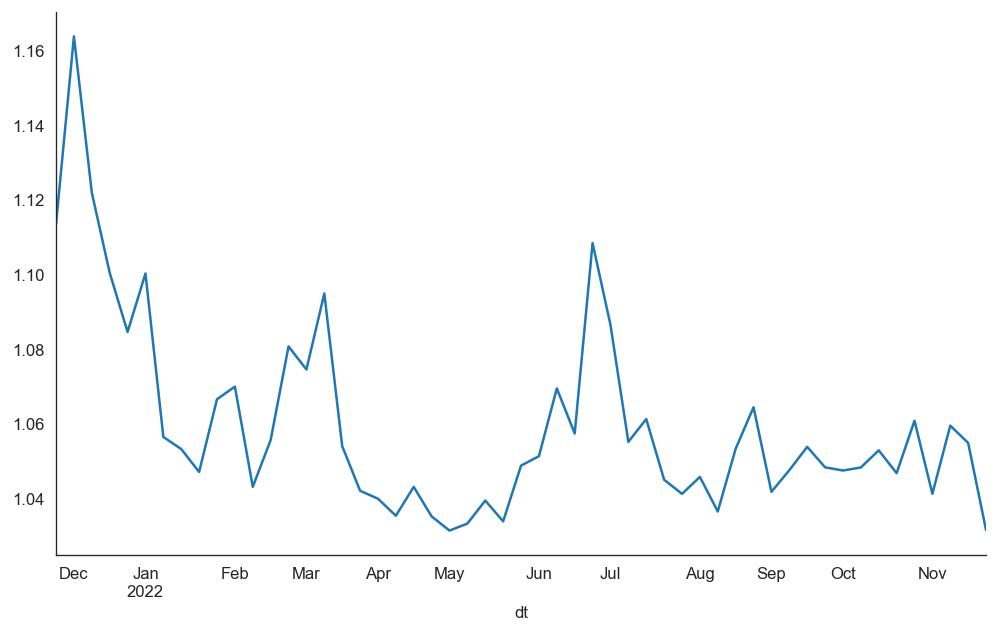

In [196]:
gtin1['cnt'].resample('W').mean().plot()

In [ ]:
#Визуализация изменения реализации товара во времени - по неделям (график без усреднения)

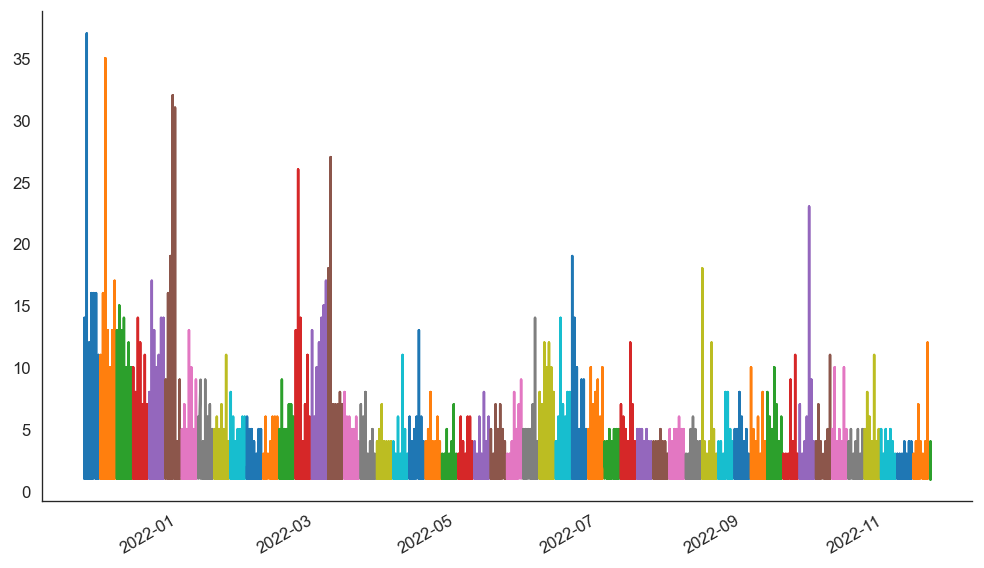

In [199]:
series = gtin1['cnt'].resample('W').plot()

In [ ]:
#Визуализация изменения цены товара во времени (среднее по неделям)

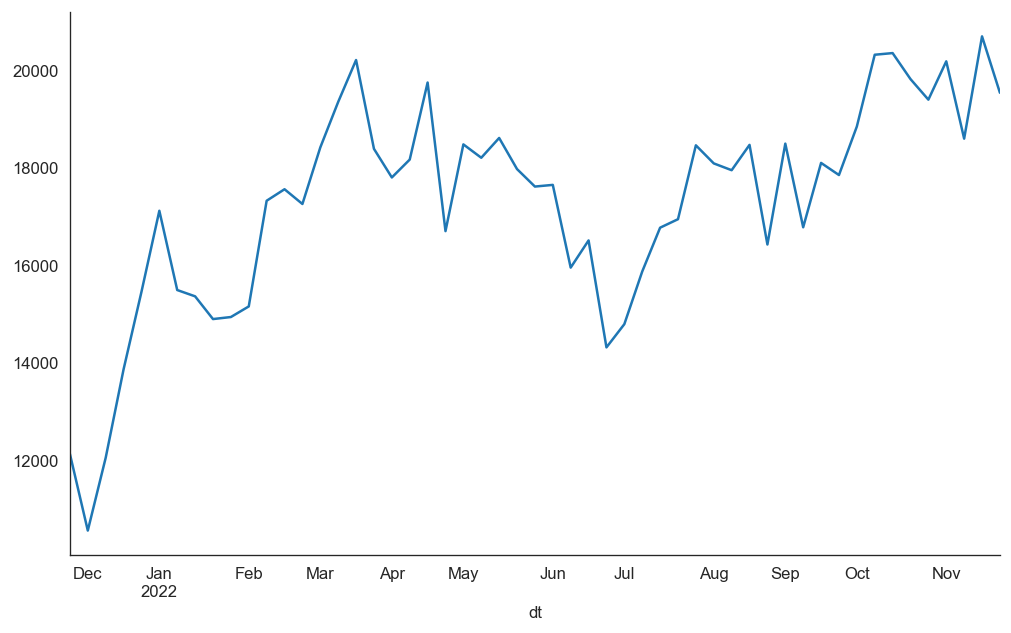

In [200]:
series = gtin1['price'].resample('W').mean().plot()

In [ ]:
#Визуализация изменения цены товара во времени (график без усреднения)

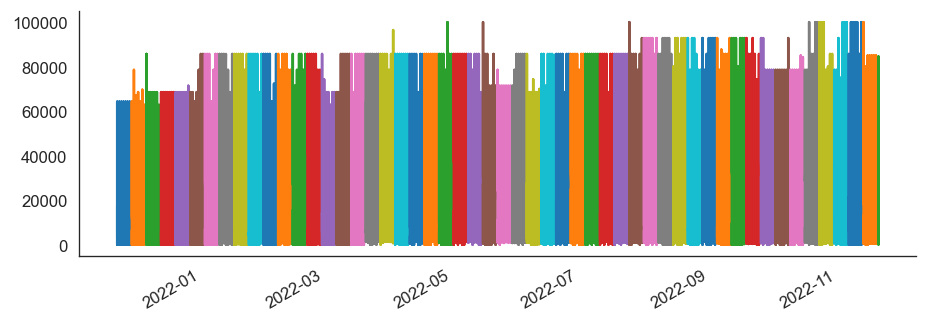

In [256]:
series = gtin1['price'].resample('W').plot()

# Подготовка данных для модели, проверяем данные на стационарность ADFuller test и KPSS. Если данные не стационарные, можно предположить необходимость наличия дифференцирования в модели ARIMA (напр. D = 1 чаще достаточно). Сделано вне рабочего кода, предназначенного для внедрения, данные не стационарные. 

# тренируем ARIMA - у модели есть параметр max_d = 1, когда она тестирует без диффенцирования и с d = 1. Сезонность - у нас данные только за один год,  определяем “seasonal” = True,  AR(p) = 1 (прогноз завтра зависит от сегодня, lags - это прошлое)

In [ ]:
#также проходимся по метрике AIC (Akaike information criterion) - чем ниже метрика, тем лучше модель

In [222]:
# разделяем на тест и трейн 
pred_periods = 100000
split_number = gtin1['cnt'].count() - pred_periods
df_train = pd.DataFrame(gtin1['cnt'][:split_number]).rename(columns={'cnt':'y_train'})
df_test = pd.DataFrame(gtin1['cnt'][split_number:]).rename(columns={'cnt':'y_test'})

In [223]:
#прописываем параметры модели, здесь обучение только на 20 тыс, потому что иначе не хватает мощностей
model_fit = pm.auto_arima(df_train.sample(20000), test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# подбираем лучшую модель, выводим
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=68.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=21889.287, Time=1.42 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=21887.897, Time=13.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=21887.901, Time=4.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=62478.903, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=21890.829, Time=0.88 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=21889.897, Time=55.70 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=42.17 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=21887.898, Time=5.35 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=96.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=21886.354, Time=15.27 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=21888.354, Time=33.99 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=30.45 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=21886.356, Time=3.40 sec
 ARIMA(0,0,0)(2,0,1)[

# Прогнозируем продажи (здесь нам нужно взять данные из будущего, которые еще не существуют, и сделать прогноз например на полгода вперед) 

In [283]:
preds, conf_int = model_fit.predict(n_periods=df_test.shape[0], return_conf_int=True)

Text(0.5, 0, 'Месяц и год')

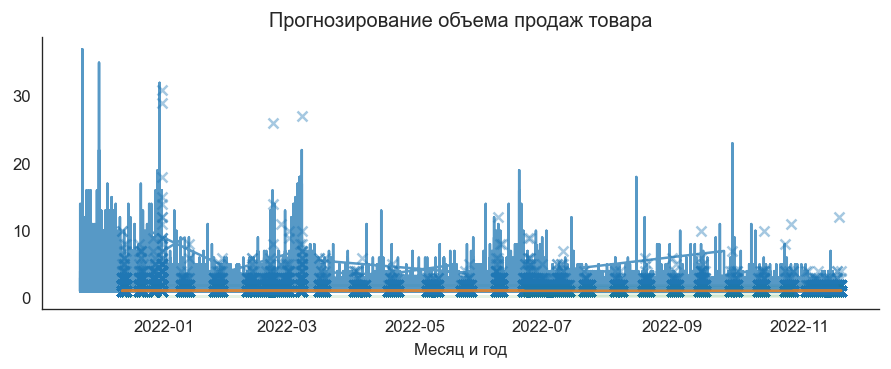

In [255]:
x_axis = np.arange(df_train.shape[0] + preds.shape[0])
x_months = gtin1.index

plt.plot(x_months[x_axis[:df_train.shape[0]]], df_train, alpha=0.75)
plt.plot(x_months[x_axis[df_train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_months[x_axis[df_train.shape[0]:]], df_test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_months[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='g')
plt.title("Прогнозирование объема продаж товара")
plt.xlabel("Месяц и год")

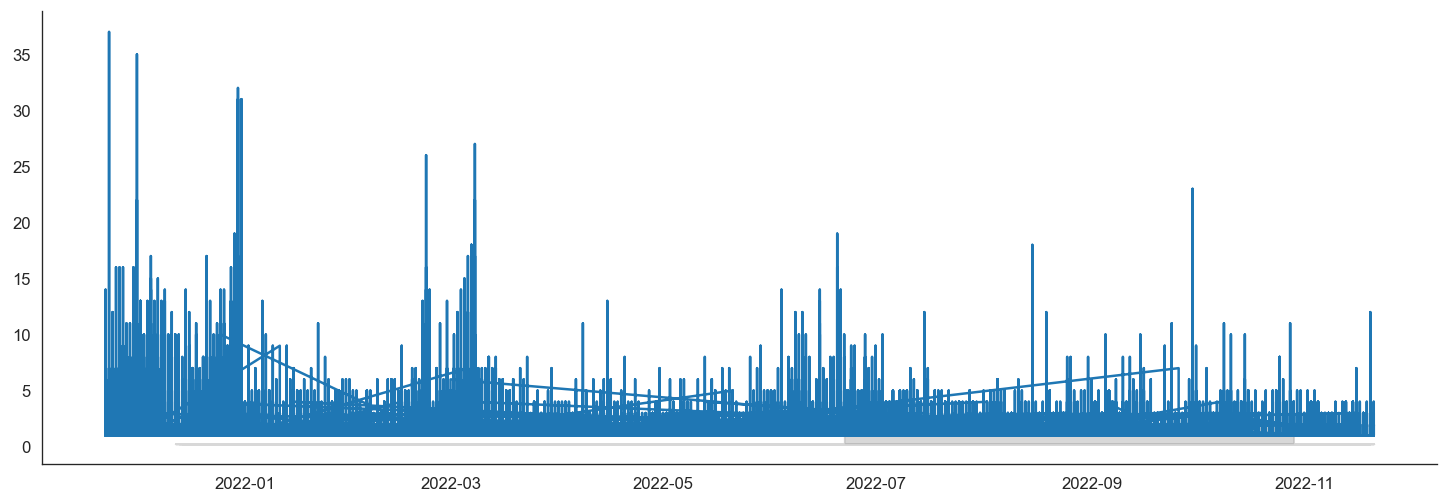

In [249]:
cf= pd.DataFrame(conf_int)
prediction_series = pd.Series(preds,index=df_test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(gtin1.cnt)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
#предсказываем на валидации